<a href="https://colab.research.google.com/github/1616232/VQO_for_state_prep/blob/main/LDP_IN_FL_COMS_673.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-federated

USING MNIST DATASET WITH LOCAL DIFFERENTIAL PIVACY

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import numpy as np

Round 0, Client 0, Loss=2.3395, Accuracy=0.1247
Round 0, Client 1, Loss=2.3450, Accuracy=0.1120
Round 0, Client 2, Loss=2.3625, Accuracy=0.1123
Round 0, Client 3, Loss=2.3565, Accuracy=0.1145
Round 0, Client 4, Loss=2.3475, Accuracy=0.1110
Round 0, Client 5, Loss=2.3799, Accuracy=0.1147
Round 0, Client 6, Loss=2.3561, Accuracy=0.1138
Round 0, Client 7, Loss=2.3549, Accuracy=0.1087
Round 0, Client 8, Loss=2.3532, Accuracy=0.1140
Round 0, Client 9, Loss=2.3581, Accuracy=0.1068
Local Loss 2.358123540878296
Local Accuracy 0.1068333312869072
Round 1, Client 0, Loss=2.2645, Accuracy=0.1585
Round 1, Client 1, Loss=2.2860, Accuracy=0.1353
Round 1, Client 2, Loss=2.2782, Accuracy=0.1487
Round 1, Client 3, Loss=2.2821, Accuracy=0.1403
Round 1, Client 4, Loss=2.2915, Accuracy=0.1325
Round 1, Client 5, Loss=2.2804, Accuracy=0.1397
Round 1, Client 6, Loss=2.2841, Accuracy=0.1420
Round 1, Client 7, Loss=2.2975, Accuracy=0.1285
Round 1, Client 8, Loss=2.2938, Accuracy=0.1218
Round 1, Client 9, Loss=2

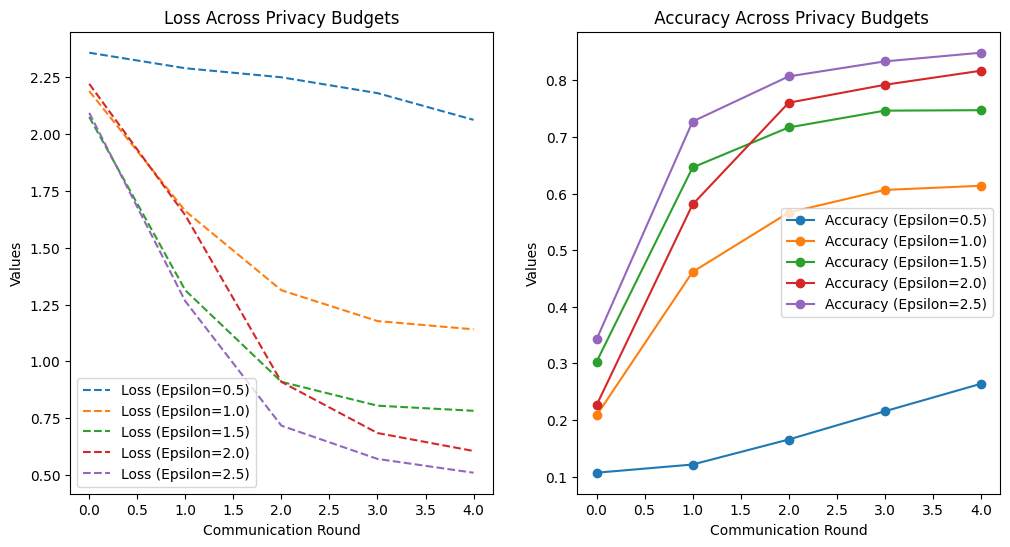

In [11]:

# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[..., np.newaxis] / 255.0  # Add channel dimension and normalize
y_train = y_train.astype(np.int32)
x_test = x_test[..., np.newaxis] / 255.0
y_test = y_test.astype(np.int32)

# Partition dataset into multiple clients
num_clients = 10
client_data = [(x_train[i::num_clients], y_train[i::num_clients]) for i in range(num_clients)]

# Parameters for Local Differential Privacy
def apply_local_dp(data, epsilon):
    """Apply local differential privacy using the Laplace mechanism."""
    sensitivity = 1.0
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale, data.shape)
    return data + noise

# Define a simple CNN model
def create_client_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')  # Ensure this matches the number of classes
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model
#Sampling Data for Each Client(This function selects data for a specific client based on its client_id.Each client gets an equal share of the dataset.)
def sample_data(x, y, client_id):
    num_samples = len(x)
    sample_per_client = num_samples // num_clients
    start_idx = client_id * sample_per_client
    end_idx = (client_id + 1) * sample_per_client
    return x[start_idx:end_idx], y[start_idx:end_idx]
#Aggregating Client Weights(Federated Learning: Combines the weights from all client models to update the global model.
#Averaging: Takes the average of weights across all clients for each layer.)
def aggregate_weights(client_models):
    num_clients = len(client_models)
    global_weights = client_models[0].get_weights()
    for layer in range(len(global_weights)):
        for client in range(1, num_clients):
            client_weights = client_models[client].get_weights()
            global_weights[layer] += client_weights[layer]
        global_weights[layer] /= num_clients
    return global_weights

# Define different privacy budgets
epsilons = [0.5, 1.0, 1.5, 2.0, 2.5]

# Initialize lists to store results
losses = []
accuracies = []
privacy_budgets = []

# Loop over different privacy budgets
for epsilon in epsilons:
    round_losses = []
    round_accuracies = []

    # Create the global model
    global_model = create_client_model()

    # Initialize client models
    client_models = [create_client_model() for _ in range(num_clients)]

    for comm_round in range(5):  # 5 communication rounds
        # Perform local training on client models
        for client_id in range(num_clients):
            client_x, client_y = sample_data(x_train, y_train, client_id)
            # Apply local differential privacy to the client data
            client_x = apply_local_dp(client_x, epsilon)
            history = client_models[client_id].fit(client_x, client_y, epochs=1, batch_size=64, verbose=0)

            # Access metrics from training history
            loss = history.history['loss'][-1]  # Get the last recorded loss
            accuracy = history.history['accuracy'][-1]  # Get the last recorded accuracy
            print(f'Round {comm_round}, Client {client_id}, Loss={loss:.4f}, Accuracy={accuracy:.4f}')

        # Aggregate client models (e.g., averaging)
        aggregated_weights = aggregate_weights(client_models)
        global_model.set_weights(aggregated_weights)

        # Evaluate the global model on the test data
        test_loss, test_accuracy = global_model.evaluate(x_test, y_test, verbose=0)
        round_losses.append(loss)
        round_accuracies.append(accuracy)
        print('Local Loss', loss)

        print('Local Accuracy', accuracy)




    losses.append(round_losses)
    accuracies.append(round_accuracies)
    privacy_budgets.append(epsilon)

# Plot the loss, accuracy, and privacy budget
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i, epsilon in enumerate(epsilons):
    plt.plot(losses[i], label=f'Loss (Epsilon={epsilon})', linestyle='--')

plt.title('Loss Across Privacy Budgets')
plt.xlabel('Communication Round')
plt.ylabel('Values')
plt.legend()

plt.subplot(1, 2, 2)
for i, epsilon in enumerate(epsilons):
    plt.plot(accuracies[i], label=f'Accuracy (Epsilon={epsilon})', marker='o')

plt.title(' Accuracy Across Privacy Budgets')
plt.xlabel('Communication Round')
plt.ylabel('Values')
plt.legend()

USING CIFAR-10 DATASET WITH LOCAL DIFFERENTIAL PIVACY

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt

Epsilon 0.1, Round 0, Client 0, Loss=3.5165, Accuracy=0.1052
Epsilon 0.1, Round 0, Client 1, Loss=3.9334, Accuracy=0.0928
Epsilon 0.1, Round 0, Client 2, Loss=4.0217, Accuracy=0.1104
Epsilon 0.1, Round 0, Client 3, Loss=4.3072, Accuracy=0.1006
Epsilon 0.1, Round 0, Client 4, Loss=3.1600, Accuracy=0.1048
Epsilon 0.1, Round 0, Client 5, Loss=3.4512, Accuracy=0.0966
Epsilon 0.1, Round 0, Client 6, Loss=3.9872, Accuracy=0.0990
Epsilon 0.1, Round 0, Client 7, Loss=3.7714, Accuracy=0.1020
Epsilon 0.1, Round 0, Client 8, Loss=5.0542, Accuracy=0.0970
Epsilon 0.1, Round 0, Client 9, Loss=3.4990, Accuracy=0.0986
Local Loss 3.498986005783081
Local Accuracy 0.09860000014305115
Epsilon 0.1, Round 1, Client 0, Loss=2.3042, Accuracy=0.1002
Epsilon 0.1, Round 1, Client 1, Loss=2.3034, Accuracy=0.1002
Epsilon 0.1, Round 1, Client 2, Loss=2.3044, Accuracy=0.0972
Epsilon 0.1, Round 1, Client 3, Loss=2.3038, Accuracy=0.0996
Epsilon 0.1, Round 1, Client 4, Loss=2.3045, Accuracy=0.1038
Epsilon 0.1, Round 1,

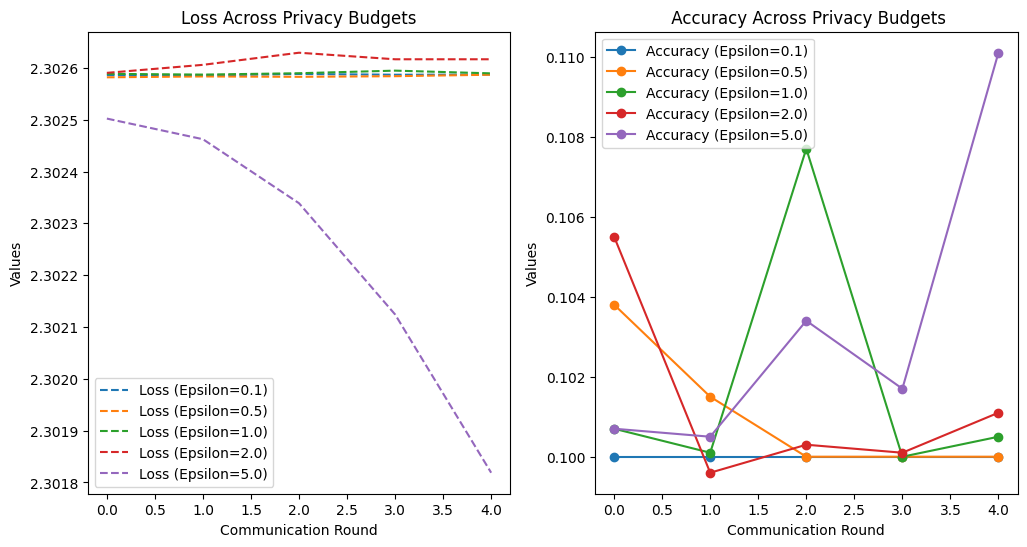

In [14]:

#  Loading and Preprocessing the CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0  # Normalize to [0, 1]
y_train = y_train.flatten().astype(np.int32)  # Flatten labels
x_test = x_test / 255.0
y_test = y_test.flatten().astype(np.int32)

#  Partitioning Data for Multiple Clients
num_clients = 10
client_data = [(x_train[i::num_clients], y_train[i::num_clients]) for i in range(num_clients)]

# Local Differential Privacy (LDP): Ensures privacy by adding Laplace noise to data.
def apply_local_dp(data, epsilon):
    """Apply local differential privacy using the Laplace mechanism."""
    sensitivity = 1.0
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale, data.shape)
    return data + noise

# Defining the Model for Each Client
def create_client_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),  # Adjust input shape for CIFAR-10
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')  # CIFAR-10 has 10 classes
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model
#Sampling Data for Each Client(This function selects data for a specific client based on its client_id.Each client gets an equal share of the dataset.)
def sample_data(x, y, client_id):
    num_samples = len(x)
    sample_per_client = num_samples // num_clients
    start_idx = client_id * sample_per_client
    end_idx = (client_id + 1) * sample_per_client
    return x[start_idx:end_idx], y[start_idx:end_idx]
#Aggregating Client Weights(Federated Learning: Combines the weights from all client models to update the global model.
#Averaging: Takes the average of weights across all clients for each layer.)
def aggregate_weights(client_models):
    num_clients = len(client_models)
    global_weights = client_models[0].get_weights()
    for layer in range(len(global_weights)):
        for client in range(1, num_clients):
            client_weights = client_models[client].get_weights()
            global_weights[layer] += client_weights[layer]
        global_weights[layer] /= num_clients
    return global_weights

# Define different privacy budgets
epsilons = [0.1, 0.5, 1.0, 2.0, 5.0]

# Initialize lists to store results
losses = []
accuracies = []
privacy_budgets = []

# Loop over different privacy budgets
for epsilon in epsilons:
    round_losses = []
    round_accuracies = []

    # Create the global model
    global_model = create_client_model()

    # Initialize client models
    client_models = [create_client_model() for _ in range(num_clients)]

    for comm_round in range(5):  # 5 communication rounds
        # Perform local training on client models
        for client_id in range(num_clients):
            client_x, client_y = sample_data(x_train, y_train, client_id)
            # Apply local differential privacy to the client data
            client_x = apply_local_dp(client_x, epsilon)
            history = client_models[client_id].fit(client_x, client_y, epochs=1, batch_size=64, verbose=0)

            # Access metrics from training history
            loss = history.history['loss'][-1]  # Get the last recorded loss
            accuracy = history.history['accuracy'][-1]  # Get the last recorded accuracy
            print(f' Round {comm_round}, Client {client_id}, Loss={loss:.4f}, Accuracy={accuracy:.4f}')

        # Aggregate client models (e.g., averaging)
        aggregated_weights = aggregate_weights(client_models)
        global_model.set_weights(aggregated_weights)

        # Evaluate the global model on the test data
        test_loss, test_accuracy = global_model.evaluate(x_test, y_test, verbose=0)
        round_losses.append(test_loss)
        round_accuracies.append(test_accuracy)
        print('Local Loss', loss)

        print('Local Accuracy', accuracy)

    losses.append(round_losses)
    accuracies.append(round_accuracies)
    privacy_budgets.append(epsilon)

# Plot the loss, accuracy, and privacy budget
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i, epsilon in enumerate(epsilons):
    plt.plot(losses[i], label=f'Loss (Epsilon={epsilon})', linestyle='--')

plt.title('Loss Across Privacy Budgets')
plt.xlabel('Communication Round')
plt.ylabel('Values')
plt.legend()

plt.subplot(1, 2, 2)
for i, epsilon in enumerate(epsilons):
    plt.plot(accuracies[i], label=f'Accuracy (Epsilon={epsilon})', marker='o')

plt.title(' Accuracy Across Privacy Budgets')
plt.xlabel('Communication Round')
plt.ylabel('Values')
plt.legend()
